TODO

- **CODE**: Generalise date input (first cell)
- **CODE**: Connect PowerBI to data source (not locally, maybe azure my onedrive)
- **CODE**: Add to AWS
- **Code**: Combine with Workout Analysis
- **Code** Theorise and create infrastructure for work days. Work binary? And then multiply by 6hrs or so which is an estimate of academic productivity during that. Or 6hrs acad 3hrs TODO.
- **Visualisations**: Monthly Preprocessing: Extract last n months to visualise (define parameter)
- **Visualisations**: Y: Total Productivity, Y: Academic vs Other, Y: Project Breakdown etc.
- **Visualisations**: Consider doing all visualisations on PowerBI and upload images here. 
- **Visualisations**: Add lineplots in addition to barplots.
- **Visualisations**: Add axhline to monthly plots with the average of each year
- **Visualisations**: Make sure (especially in workouts monthly plot) that if a month from new data has 0 workouts that it still shows that month in the vis and doesnt skip it

In [95]:
import requests
from base64 import b64encode

import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# date = datetime.datetime.strptime('2022/10/13', '%Y/%m/%d')
# date = str(int(datetime.datetime.timestamp(date)*1000))
# print(date)

data_start_date = '2022-10-01'
data_end_date = '2022-11-01'

data = requests.get(url='https://api.track.toggl.com/api/v9/me/time_entries', 
                    headers={'content-type': 'application/json', 'Authorization' : 'Basic %s' %  b64encode(b"johnspinkles@gmail.com:Q1w2e3r4").decode("ascii")}, 
                    params={'start_date': data_start_date, 'end_date': data_end_date})

def preprocess(data):
    
    df = pd.DataFrame(data.json())
    df = df[['project_id', 'description', 'duration', 'start', 'stop']]

    df.duration = df.duration / 3600
    df['start'] = pd.to_datetime(df.start, yearfirst=True).dt.tz_localize(None)
    df['stop'] = pd.to_datetime(df.start, yearfirst=True).dt.tz_localize(None)
    
    df = df.rename(columns={'project_id': 'Project', 'start': 'Start', 'stop': 'End', 'duration': 'Duration (hrs)', 'description': 'Description'})
    df.Project = df.Project.map({161348235: 'Data Science', 
                                        152934507: 'To-Do', 
                                        185888440: 'Weight', 
                                        185969011: 'Social', 
                                        152934491: 'Notes', 
                                        185970865: 'Workout'})
    
    # Drop current entry (that is not finished) because it leads to extremely high negative duration 
    df = df.drop(df.index[df['Duration (hrs)'] < 0])
    
    return df

df = preprocess(data)
df

,Project,Description,Duration (hrs),Start,End
0,Data Science,PYTHON-Track,0.022500,2022-10-15 13:24:45,2022-10-15 13:24:45
1,Data Science,PYTHON-Track,0.002500,2022-10-15 13:24:31,2022-10-15 13:24:31
2,Data Science,PYTHON-Track,0.003333,2022-10-15 13:22:52,2022-10-15 13:22:52
3,Data Science,PYTHON-Track,0.028889,2022-10-15 13:21:01,2022-10-15 13:21:01
4,Data Science,PYTHON-Track,0.036111,2022-10-15 13:17:37,2022-10-15 13:17:37
...,...,...,...,...,...
361,To-Do,JOBS,0.717222,2022-10-01 09:38:51,2022-10-01 09:38:51
362,To-Do,JOBS,0.206111,2022-10-01 08:36:47,2022-10-01 08:36:47
363,To-Do,GENERAL,0.180556,2022-10-01 08:29:49,2022-10-01 08:29:49
364,Weight,70.3,0.004722,2022-10-01 08:22:27,2022-10-01 08:22:27


### 🔵 Preprocessing

In [96]:
print('Unique Projects: ')
for i in range(df.Project.unique().shape[0]):
    print('-', df.Project.unique()[i])

Unique Projects: 
- Data Science
- To-Do
- Workout
- Notes
- Social
- Weight


### 🔵 M: Project Breakdown
My PowerBI Report: 

![alt text](powerbi_month_report.png)

In [97]:
def project_preprocess(df):
    
    df = df[['Project', 'Description', 'Duration (hrs)', 'Start']]
    df = df.rename({'Start': 'Date'})
    df = df.join(df.Description.str.split('-', expand=True).rename(columns={0:'Specific1', 1:'Specific2', 2:'Specific3'}))
    df = df.drop(['Description'], axis=1)
    
    return df
    
df_projects = df.copy()
df_projects = project_preprocess(df_projects)
df_projects.to_csv('new_data.csv')
df_projects

,Project,Duration (hrs),Start,Specific1,Specific2,Specific3
0,Data Science,0.022500,2022-10-15 13:24:45,PYTHON,Track,None
1,Data Science,0.002500,2022-10-15 13:24:31,PYTHON,Track,None
2,Data Science,0.003333,2022-10-15 13:22:52,PYTHON,Track,None
3,Data Science,0.028889,2022-10-15 13:21:01,PYTHON,Track,None
4,Data Science,0.036111,2022-10-15 13:17:37,PYTHON,Track,None
...,...,...,...,...,...,...
361,To-Do,0.717222,2022-10-01 09:38:51,JOBS,None,None
362,To-Do,0.206111,2022-10-01 08:36:47,JOBS,None,None
363,To-Do,0.180556,2022-10-01 08:29:49,GENERAL,None,None
364,Weight,0.004722,2022-10-01 08:22:27,70.3,None,None


In [98]:
print('Unique Projects: ')
for proj in df_projects.Project.unique():
    print('   -', proj)

Unique Projects: 
   - Data Science
   - To-Do
   - Workout
   - Notes
   - Social
   - Weight


### 🔵 Y: Preprocessing
1. Preprocess all current data for monthly visualisation

2. Preprocess all old data 

3. Concatenate old and new

In [99]:
# drop projects with 0 duration (where no work was done on that month. automatically defaults to 0 in visualisation)
#df_productive.drop(df_productive[df_productive['Duration (hrs)'] == 0.].index)

def monthly_preprocess(df):
    '''NEW DATA: Oct 2022 - Present'''
    
    # General
    data = df.copy()
    data = data.rename(columns={'Start': 'Date'})
    data['Date'] = data['Date'].dt.strftime('%b %y')
    
    # Productivity df
    df_productive = data.groupby([data['Date'], 'Project'], sort=False, as_index=False).sum()
    df_productive = df_productive[data.Project != 'Weight']
    
    # Weight df
    df_weight = data[data.Project == 'Weight']
    df_weight = df_weight.drop(['Project', 'End', 'Duration (hrs)'], axis=1)
    df_weight = df_weight.rename({'Description': 'Weight (kg)'}, axis=1)
    
    # Social df
    df_social = data[data.Project == 'Social']
    df_social = df_social.drop(['End', 'Duration (hrs)'], axis=1)
    
    
    return df_productive, df_weight, df_social

def monthly_preprocess_old():
    
    '''OLD DATA: January 2019 - Sept 2022'''
    
    try:
        old_data=pd.read_csv('old_data_pre.csv')
    except:
        print('old_data.csv not found.')
        
    old_data['Date'] = pd.to_datetime(old_data['Date'], dayfirst=True)
    old_data['Date'] = old_data['Date'].dt.strftime('%b %y')
    old_data = old_data.rename(columns={'Duration': 'Duration (hrs)'})
    old_weight = old_data[old_data.Project == 'Weight']    # extract weight
    old_weight = old_weight.drop('Project', axis=1)
    old_weight = old_weight.rename(columns={'Duration (hrs)': 'Weight (kg)'})
    old_data = old_data[old_data.Project != 'Weight']
    old_data['Duration (hrs)'] = old_data['Duration (hrs)'] / 2    # CGP to hrs
    
    return old_data, old_weight

def monthly_concat(df_productive, df_old, df_weight, df_weight_old):

    df_productive = pd.concat([df_old, df_productive])
    df_productive.reset_index(inplace=True)
    df_productive = df_productive.drop('index', axis=1)

    df_weight = pd.concat([df_weight_old, df_weight])
    df_weight.reset_index(inplace=True)
    df_weight.drop('index', axis=1, inplace=True)
    df_weight['Weight (kg)'] = df_weight['Weight (kg)'].astype(float)
    
    return df_productive, df_weight

In [100]:
# NEW DATA: Oct 2022 - Present
df_productive, df_weight, df_social = monthly_preprocess(df)

# OLD DATA: January 2019 - Sept 2022
df_old, df_weight_old = monthly_preprocess_old()

# COMBINE
df_productive, df_weight = monthly_concat(df_productive, df_old, df_weight, df_weight_old)

# EXPORT
df_productive.to_csv(f'old_data.csv', index=False)       # Total data
df_weight.to_csv(f'weight.csv', index=False)    # Total weight data

# Export Workout data
df_workout = df_productive[df_productive.Project=='Workout']
df_workout.to_csv(f'workout.csv', index=False)  # Total workout data


C:\Users\johng\AppData\Local\Temp\ipykernel_22548\3942472395.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_productive = df_productive[data.Project != 'Weight']


### 🔵 Y: Function: Single Barchart

In [101]:
def plot_monthly_single_barchart(df, title='', color='#A418FF', y_axis= 'Duration (hrs)', y_min=0, figsize=(20,6), legendsize=10, title_size=20, title_pad = 15, bar_label_size=17, x_tick_size = 14, y_tick_size = 13, y_label_size=15, x_tick_rotation = 60): 
    '''
    df: (pandas DF) dataframe with col 1: Date, col 2: Project, col 3: Duration (hrs)
    title: (String) title of the plot
    color: (String) choose from https://htmlcolorcodes.com/, add a hashtag before the code
    
    '''


    plt.style.use('fivethirtyeight') 
    plt.figure(figsize=figsize)
    y_lim = df[y_axis].max() + df[y_axis].max() * 0.20


    ax = sns.barplot(x='Date', y=y_axis, data=df, color=color, ci=None, linewidth=1, edgecolor="k")
    plt.xlabel('')
    plt.ylabel(y_axis, fontsize=y_label_size)
    plt.title(title, fontsize=title_size, fontweight='bold', pad=title_pad)
    plt.ylim([y_min, y_lim])                                                    # Expand y axis range for visibility
    ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
    ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
    #ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_tick_rotation)


    line_locs = []
    line_year = []
    for count, value in enumerate(df.Date):
        if value.startswith('Jan'):
            line_locs.append(count)
            line_year.append('20'+value[-2:])
    for loc, year in zip(line_locs, line_year):
        plt.axvline(x = loc-0.5, color = 'lightblue', label = 'Year', linewidth=4)
        ax.text(loc-0.5 + 5, y_lim - 0.07*y_lim, year, fontsize = 20, 
             bbox = dict(facecolor = 'lightblue', alpha = 0.5))


    plt.show()

### 🔵 Y: Function: Generalise Barchart

In [102]:
# colors = {'Other': "#FFBC18", 
#           'Academic': "#33B2FF"}
# hue_order = ['Academic', 'Other']

# ax = sns.lineplot(x='Date', y='Duration (hrs)', data=df_acad_other, hue='Project', ci=None, palette=colors, hue_order=hue_order)

# plt.legend(title = 'Project Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# plt.show()

In [103]:
def plot_monthly_barchart(df, multi_bar=False, title='', color='#A418FF', y_axis= 'Duration (hrs)', y_min=0, figsize=(20,6), legendsize=10, title_size=20, title_pad = 15, bar_label_size=17, x_tick_size = 14, y_tick_size = 13, y_label_size=15, x_tick_rotation = 60, palette='rocket_r', hue_order=['']): 
    '''
    df: (pandas DF) dataframe with col 1: Date, col 2: Project, col 3: Duration (hrs)
    double: (boolean) whether a single or a double (or multiple) barchart should be built. I.e. more than one column per date
    title: (String) title of the plot
    color: (String) choose from https://htmlcolorcodes.com/, add a hashtag before the code
    
    '''


    plt.style.use('fivethirtyeight') 
    plt.figure(figsize=figsize)
    y_lim = df[y_axis].max() + df[y_axis].max() * 0.20

    if multi_bar:
        ax = sns.barplot(x='Date', y=y_axis, data=df, color=color, hue='Project', ci=None, linewidth=1, edgecolor="k", palette=palette, hue_order=hue_order)
        plt.legend(title = 'Project Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        
        line_locs = []
        line_year = []
        for count, value in enumerate(df.Date):
            if value.startswith('Jan'):
                line_locs.append(count)
                line_year.append('20'+value[-2:])
        for loc, year in zip(line_locs, line_year):
            plt.axvline(x = loc-0.5, color = 'lightblue', label = 'Year', linewidth=4)
            ax.text(loc-0.5 + 5, y_lim - 0.07*y_lim, year, fontsize = 20, 
                 bbox = dict(facecolor = 'lightblue', alpha = 0.5))
        
    else:
        ax = sns.barplot(x='Date', y=y_axis, data=df, color=color, ci=None, linewidth=1, edgecolor="k")
        
        line_locs = []
        line_year = []
        for count, value in enumerate(df.Date):
            if value.startswith('Jan'):
                line_locs.append(count)
                line_year.append('20'+value[-2:])
        for loc, year in zip(line_locs, line_year):
            plt.axvline(x = loc-0.5, color = 'lightblue', label = 'Year', linewidth=4)
            ax.text(loc-0.5 + 5, y_lim - 0.07*y_lim, year, fontsize = 20, 
                 bbox = dict(facecolor = 'lightblue', alpha = 0.5))
    
    plt.xlabel('')
    plt.ylabel(y_axis, fontsize=y_label_size)
    plt.title(title, fontsize=title_size, fontweight='bold', pad=title_pad)
    plt.ylim([y_min, y_lim])                                                    # Expand y axis range for visibility
    ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
    ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
    #ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_tick_rotation)


    


    plt.show()

In [104]:
#plot_monthly_barchart(df_acad_other, multi_bar=True)

### 🔵 Y: Weight & Workout

#### 🔴Weight

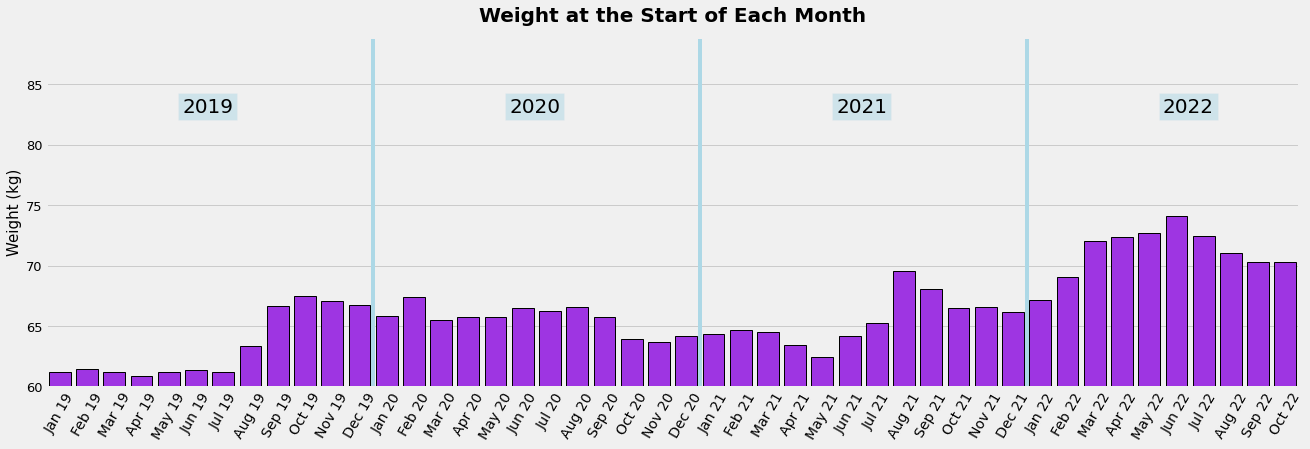

In [105]:
plot_monthly_single_barchart(df_weight, y_axis='Weight (kg)', title='Weight at the Start of Each Month', y_min=60)


# ax=sns.lineplot(x='Date', y='Weight (kg)', data=df_weight)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# plt.show()

#### 🔴 Workout

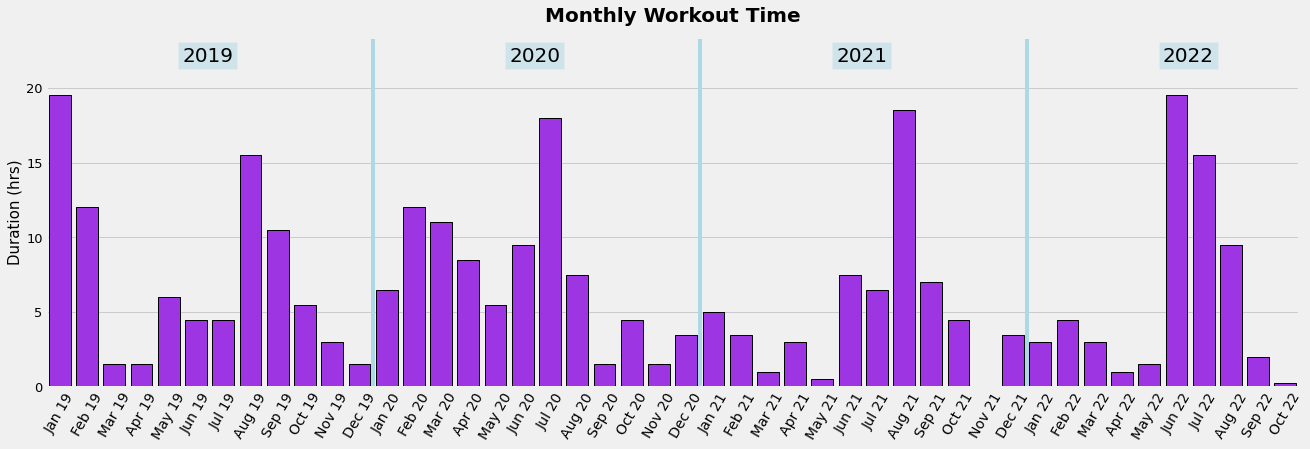

In [106]:
plot_monthly_single_barchart(df_workout, 'Monthly Workout Time')

### 🔵 Y: Total Productivity

In [107]:
# All
df_total = df_productive.copy()
df_total = df_total[df_total.Project != 'Social']
for project in df_total.Project.unique():
    df_total['Project'].replace(project, 'All', inplace=True)
df_total = df_total.groupby('Date', sort=False).sum()
df_total.reset_index(inplace=True)



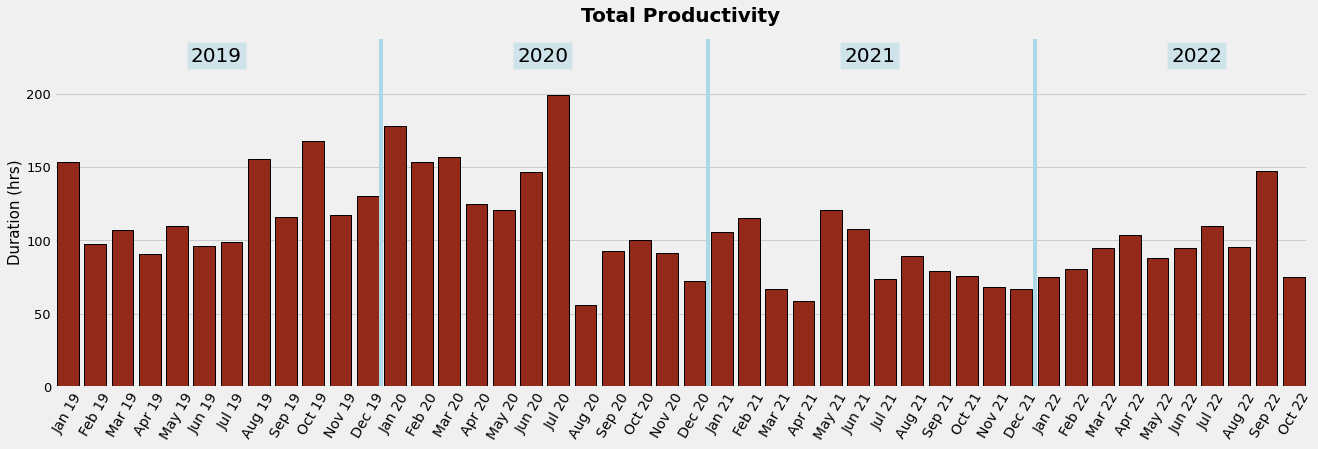

In [108]:
plot_monthly_single_barchart(df=df_total, title='Total Productivity', color='#A71A03')

### 🔵 Y: Academic vs Other Productivity
**Academic**
- Notes
- Data Science

**Other**
- To-Do
- Piano
- Workout

In [109]:
# Acad vs other data
df_acad_other = df_productive.copy()
df_acad_other = df_acad_other[df_acad_other.Project != 'Social']
df_acad_other['Project'].replace('Data Science', 'Academic', inplace=True)
df_acad_other['Project'].replace('Notes', 'Academic', inplace=True)
df_acad_other['Project'].replace('University', 'Academic', inplace=True)
df_acad_other['Project'].replace('To-Do', 'Other', inplace=True)
df_acad_other['Project'].replace('Piano', 'Other', inplace=True)
df_acad_other['Project'].replace('Workout', 'Other', inplace=True)
df_acad_other = df_acad_other.groupby(['Date', 'Project'], sort=False, as_index=False).sum()

In [110]:
df_acad_other.Project.unique()

array(['Academic', 'Other', 'Weight'], dtype=object)

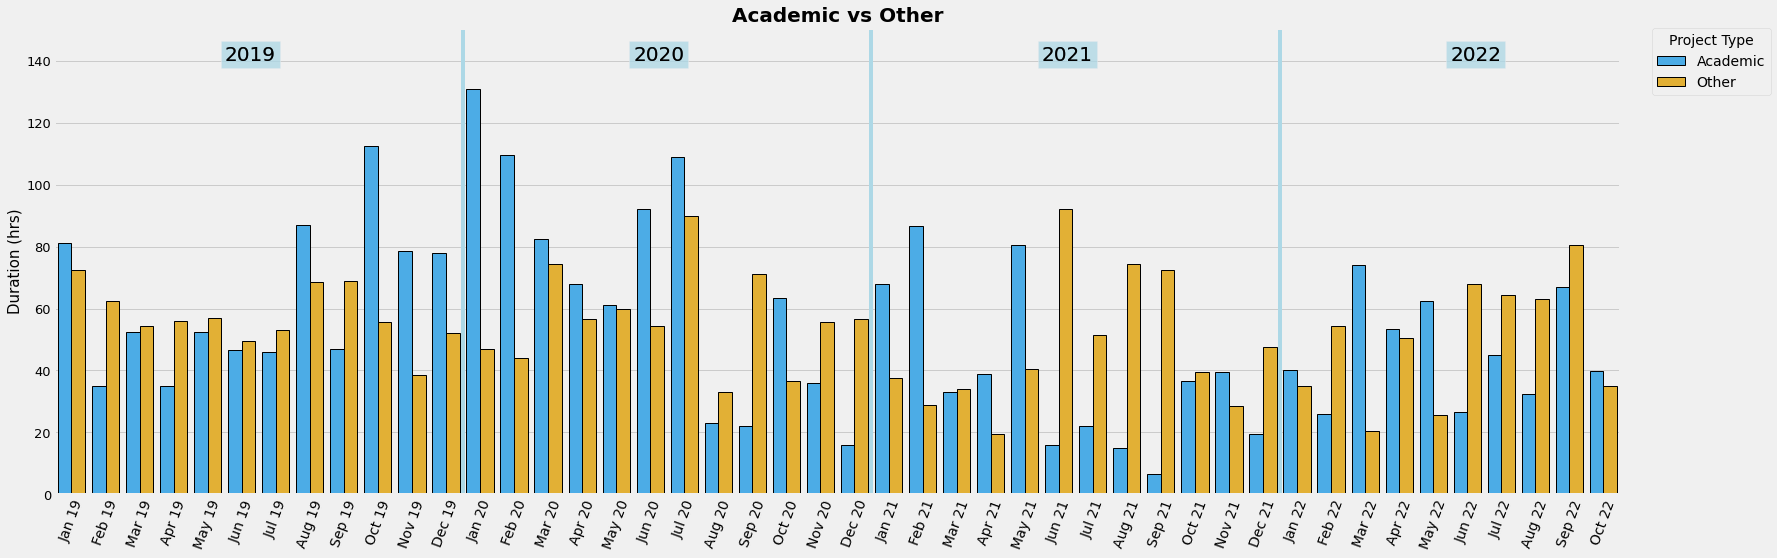

C:\Users\johng\AppData\Local\Temp\ipykernel_22548\1257455441.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


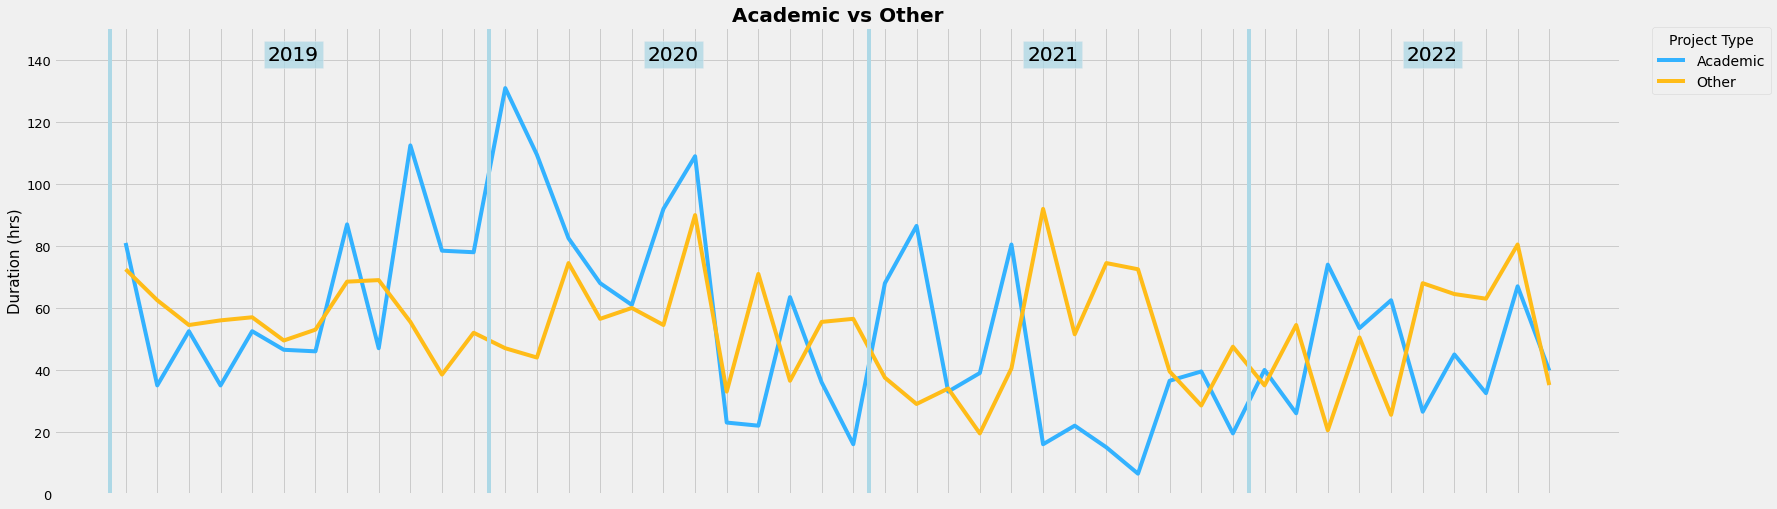

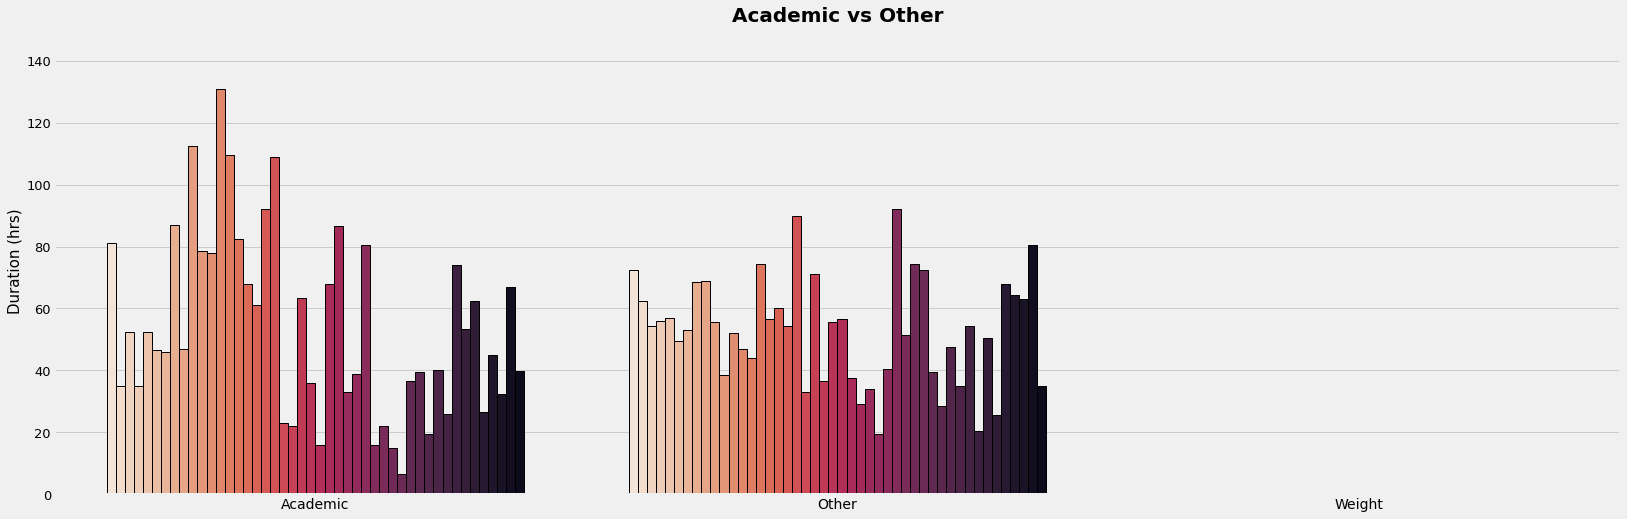

In [111]:
legendsize=10
title_size=20
title_pad = 15
bar_label_size=17
x_tick_size = 14
y_tick_size = 13
y_label_size=15
x_tick_rotation = 60
figsize=((25, 8))

title='Academic vs Other'


y_lim = df_acad_other['Duration (hrs)'].max() + df_acad_other['Duration (hrs)'].max() * 0.15

plt.style.use('fivethirtyeight') 
plt.figure(figsize=figsize)

# Set your custom color palette https://htmlcolorcodes.com/

colors = {'Other': "#FFBC18", 
          'Academic': "#33B2FF"}
hue_order = ['Academic', 'Other']


ax = sns.barplot(x='Date', y='Duration (hrs)', data=df_acad_other, hue='Project', ci=None, palette=colors, hue_order=hue_order, linewidth=1, edgecolor="k")
plt.xlabel('')
plt.ylabel('Duration (hrs)', fontsize=15)
plt.title(title, fontsize=title_size, fontweight='bold')
plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
plt.legend(title = 'Project Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



line_locs = []
line_year = []
for count, value in enumerate(df_acad_other.Date):
    if value.startswith('Jan'):
        line_locs.append(count)
        line_year.append('20'+value[-2:])
#line_locs = [count for count, value in enumerate(df_acad_other.Date) if value.startswith('Jan')]
for loc, year in zip(line_locs, line_year):
    plt.axvline(x = loc//2-0.5, color = 'lightblue', label = 'Year', linewidth=4)
    ax.text(loc//2-0.5 + 5, y_lim - 0.07*y_lim, year, fontsize = 20, 
         bbox = dict(facecolor = 'lightblue', alpha = 0.5))


plt.show()






'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''







title='Academic vs Other'


y_lim = df_acad_other['Duration (hrs)'].max() + df_acad_other['Duration (hrs)'].max() * 0.15

plt.style.use('fivethirtyeight') 
plt.figure(figsize=figsize)

# Set your custom color palette https://htmlcolorcodes.com/

colors = {'Other': "#FFBC18", 
          'Academic': "#33B2FF"}
hue_order = ['Academic', 'Other']


ax = sns.lineplot(x='Date', y='Duration (hrs)', data=df_acad_other, hue='Project', ci=None, palette=colors, hue_order=hue_order)
plt.xlabel('')
plt.ylabel('Duration (hrs)', fontsize=15)
plt.title(title, fontsize=title_size, fontweight='bold')
plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.legend(title = 'Project Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


line_locs = []
line_year = []
for count, value in enumerate(df_acad_other.Date):
    if value.startswith('Jan'):
        line_locs.append(count)
        line_year.append('20'+value[-2:])
#line_locs = [count for count, value in enumerate(df_acad_other.Date) if value.startswith('Jan')]
for loc, year in zip(line_locs, line_year):
    plt.axvline(x = loc//2-0.5, color = 'lightblue', label = 'Year', linewidth=4)
    ax.text(loc//2-0.5 + 5, y_lim - 0.07*y_lim, year, fontsize = 20, 
         bbox = dict(facecolor = 'lightblue', alpha = 0.5))




plt.show()








'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''









title='Academic vs Other'
sns.set_palette(sns.color_palette("rocket_r"))
#sns.set_palette(sns.dark_palette("#69d", reverse=True, as_cmap=True))

y_lim = df_acad_other['Duration (hrs)'].max() + df_acad_other['Duration (hrs)'].max() * 0.15

plt.style.use('fivethirtyeight') 
plt.figure(figsize=figsize)

# Set your custom color palette https://htmlcolorcodes.com/

colors = {'Other': "#FFBC18", 'Academic': "#33B2FF"}


ax = sns.barplot(x='Project', y='Duration (hrs)', data=df_acad_other, hue='Date', ci=None, palette = 'rocket_r', linewidth=1, edgecolor="k")
plt.xlabel('')
plt.ylabel('Duration (hrs)', fontsize=15)
plt.title(title, fontsize=title_size, fontweight='bold')
plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars
plt.legend([],[], frameon=False)

plt.show()


### 🔵 ALL: Total Productivity